In [4]:

import pandas as pd
def get_df():
    df = pd.read_excel(fr"C:\Users\halik\OneDrive\Dokumenty\GitHub\predikce-nabidky\funcni data set - Copy.xlsx")
    df = df.drop(df.index[:13])
    df = df.drop(df.index[-1:])
    df['datetime'] = pd.date_range(start='2016-03-01', periods=85, freq='MS')
    return df
get_df()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\halik\\OneDrive\\Dokumenty\\GitHub\\predikce-nabidky\\funcni data set - Copy.xlsx'

detrendování dat

In [ ]:
df = get_df()
df_detrend = df.copy()
parametry = ['aktivni-1', 'nove-1', 'zbytek-1']
columns = ['aktivni', *parametry]
for column in columns:
    df_detrend[column] = pd.Series((df[column]))

deseasonalizování dat

In [ ]:
import statsmodels.api as sm
df_deseasoned = df_detrend.copy()
for parametr in parametry:
    decomp = sm.tsa.seasonal_decompose(df_detrend[parametr], period=12, model='additive')
    df_deseasoned[parametr] = df_detrend[parametr] - decomp.seasonal.values

grafy

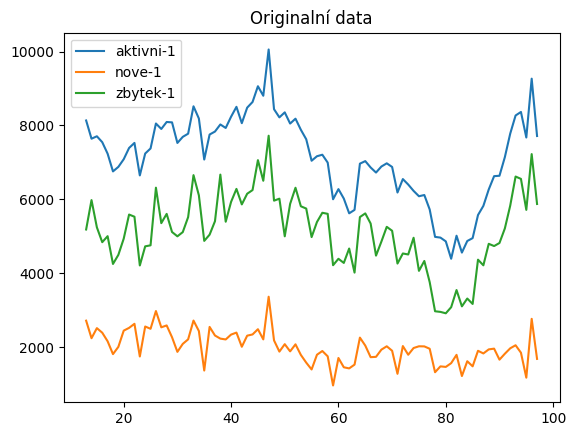

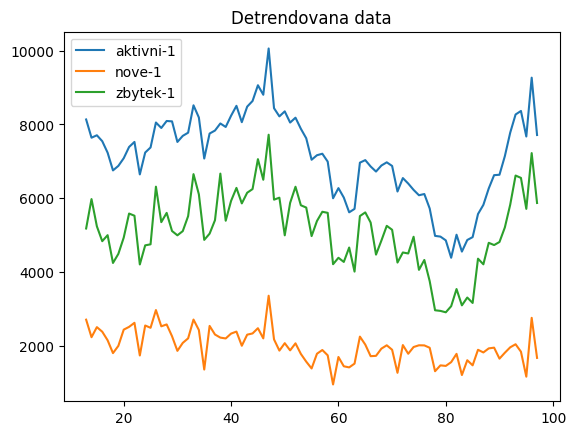

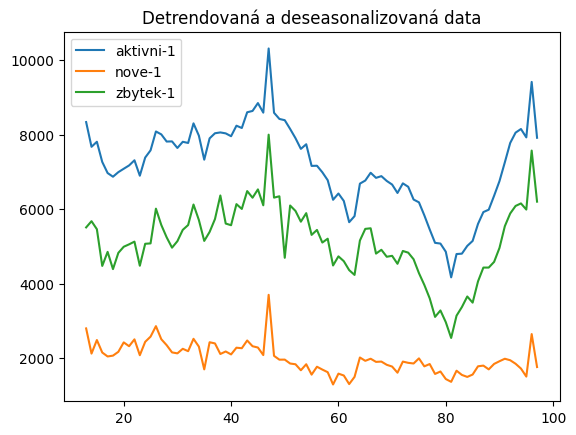

In [ ]:
from matplotlib import pyplot as plt
#>> originalni data
plt.plot(df.index, df['aktivni-1'], label='aktivni-1')
plt.plot(df.index, df['nove-1'], label='nove-1')
plt.plot(df.index, df['zbytek-1'], label='zbytek-1')
plt.legend()
plt.title('Originalní data')
plt.show()
#>> detrendovana data
plt.plot(df.index, df_detrend['aktivni-1'], label='aktivni-1')
plt.plot(df.index, df_detrend['nove-1'], label='nove-1')
plt.plot(df.index, df_detrend['zbytek-1'], label='zbytek-1')
plt.legend()
plt.title('Detrendovana data')
plt.show()
#>> detrendovana a deseasonalizovana data
plt.plot(df.index, df_deseasoned['aktivni-1'], label='aktivni-1')
plt.plot(df.index, df_deseasoned['nove-1'], label='nove-1')
plt.plot(df.index, df_deseasoned['zbytek-1'], label='zbytek-1')
plt.legend()
plt.title('Detrendovaná a deseasonalizovaná data')
plt.show()

OLS model

Mean absolute error (train set): 308.49
Mean squared error (train set): 201120.68
Root mean squared error (train set): 448.46
r2 (train set): 0.86


Mean absolute error (test set): 603.18
Mean squared error (test set): 550969.94
Root mean squared error (test set): 742.27
r2 (test set): 0.42


                            OLS Regression Results                            
Dep. Variable:                aktivni   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     177.9
Date:                Thu, 11 May 2023   Prob (F-statistic):           5.09e-21
Time:                        18:03:03   Log-Likelihood:                -549.31
No. Observations:                  73   AIC:                             1103.
Df Residuals:                      71   BIC:                             1107.
Df Model:                           1                                     

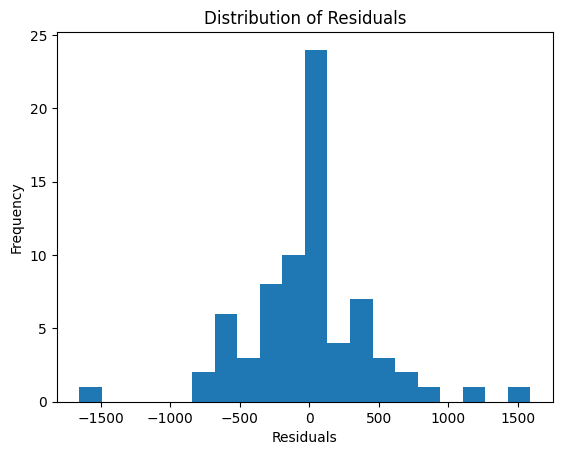

CPU times: total: 125 ms
Wall time: 509 ms


In [ ]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics
from sklearn.metrics import classification_report, r2_score

import statsmodels.api as sm
from statsmodels.tools import add_constant

#*defiunovani dat
#@parametry
parametry = ['aktivni-1']
X = df_deseasoned[parametry]
y = df_deseasoned['aktivni']

#*Add a constant term to the training and testing data
X = add_constant(X)

#* training dataframe bez randomizace
X_train = X.drop(X.index[-12:])
y_train = y.drop(y.index[-12:])
#* testing dataframe bez randomizace
X_test = X.drop(X.index[:-12])
X_test = X_test.drop(X_test.index[-1:])
y_test = y.drop(y.index[:-12])
y_test = y_test.drop(y_test.index[-1:])


#* fitnuti ols_model modelu na train datech
ols_model = sm.OLS(y_train, X_train).fit(cov_type='HC0')

#*predikce na train datech
y_pred_train = ols_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

#*predikce na test setu
y_pred_test = ols_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

#>> output
print(f"Mean absolute error (train set): {mae_train:.2f}")
print(f"Mean squared error (train set): {mse_train:.2f}")
print(f"Root mean squared error (train set): {rmse_train:.2f}")
print(f"r2 (train set): {r2_train:.2f}")
print("\n")
print(f"Mean absolute error (test set): {mae_test:.2f}")
print(f"Mean squared error (test set): {mse_test:.2f}")
print(f"Root mean squared error (test set): {rmse_test:.2f}")
print(f"r2 (test set): {r2_test:.2f}")
print("\n")
print(ols_model.summary())
# plot the distribution of residuals
residuals = y_train - y_pred_train
plt.hist(residuals, bins=20)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

predikce

In [ ]:

#! nemusim k predikcim pridavat sezonost a trend protoze jsem je nikdy neodebral z 'aktinvi'
X_new = X.drop(X.index[:-1])
y_pred = ols_model.predict(X_new)
predikce = y_pred
print(f"""
Model:      {ols_model}
Min:        {int(y_pred-rmse_test)}
Predikce:   {int(y_pred)}
Max:        {int(y_pred+rmse_test)}
Rmse:       {int(rmse_test)}
""")


Model:      <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000156AF3FFD90>
Min:        7092
Predikce:   7834
Max:        8576
Rmse:       742



graf predikce

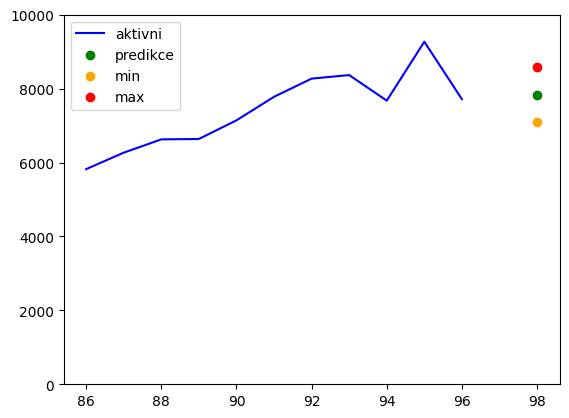

In [ ]:
#* realita
plt.plot(y_test.index, y_test.values,label="aktivni",color="blue")
#* predikce
plt.scatter(X_new.index+1, y_pred.values, label='predikce', color="green")
plt.scatter(X_new.index+1, y_pred.values-rmse_test, label='min', color="orange")
plt.scatter(X_new.index+1, y_pred.values+rmse_test, label='max', color="red")
plt.ylim(0,10000)
plt.legend()
plt.show()

grafy vztahů

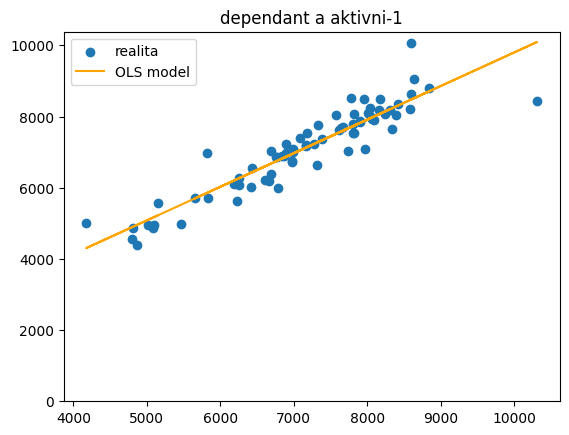

In [ ]:

parametry = ['aktivni-1']
for parametr in parametry:
    plt.scatter( X_train[parametr], y_train, label="realita")
    plt.plot(X_train[parametr], y_pred_train, color="orange", label="OLS model")
    plt.ylim(0)
    plt.legend()
    plt.title(f'dependant a {parametr}')
    plt.show()


Graf model vs realita

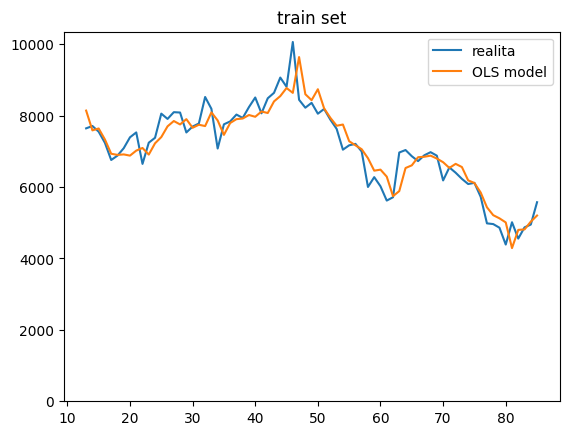

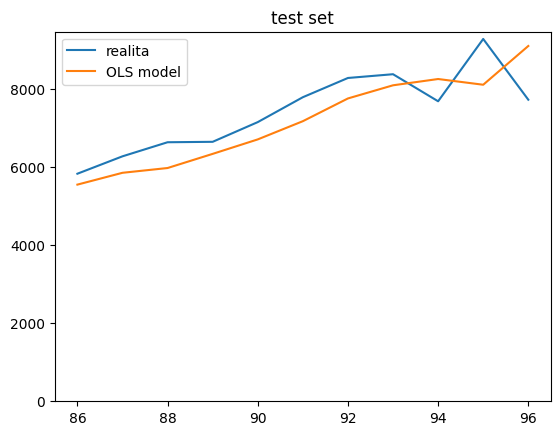

In [ ]:
plt.plot(X_train.index, y_train, label='realita')
plt.plot(X_train.index, y_pred_train, label='OLS model')
plt.title('train set')
plt.legend()
plt.ylim(0)
plt.show()

plt.plot(X_test.index, y_test, label='realita')
plt.plot(X_test.index, y_pred_test, label='OLS model')
plt.title('test set')
plt.legend()
plt.ylim(0)
plt.show()


autokorelace 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df['aktivni'])
plt.show
plot_acf(df_deseasoned['aktivni'])
plt.show()
plot_pacf(df_deseasoned['aktivni'])
plt.show()

NameError: name 'df' is not defined